In [55]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Convolution2D,Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(patience=12, restore_best_weights=True )

In [56]:
#loading data
train_folder="/kaggle/input/intel-image-classification/seg_train/seg_train"
valid_folder="/kaggle/input/intel-image-classification/seg_test/seg_test"

In [57]:
# We can check image shape using this code
import cv2
import numpy as np

# Load the image
image = cv2.imread('/kaggle/input/intel-image-classification/seg_train/seg_train/sea/10053.jpg')

# Check the shape of the image
height, width, channels = image.shape
# Dataset comprises of images of shape: (150,150,3)
# Print the image shape
print(f"Image shape: (height={height}, width={width}, channels={channels})")

Image shape: (height=150, width=150, channels=3)


In [59]:
#data augmentation for training and testing
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rescale=1./255,   # Rescale pixel values to [0, 1]
    horizontal_flip=True  # Random horizontal flipping
    )

test_datagen=ImageDataGenerator(rescale=1./255)

In [72]:
# Create a generator for training data

train_ds = train_datagen.flow_from_directory(
  train_folder,   # Path to the training data
  seed=123,
  target_size=(224, 224), # Resize images to this size
  batch_size=32  , # Number of images in each batch
  class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 14034 images belonging to 6 classes.


In [73]:
# Create a generator for testing data
val_ds = test_datagen.flow_from_directory(
  valid_folder,
  seed=123,
  target_size=(224, 224),
  batch_size=32)

Found 3000 images belonging to 6 classes.


In [61]:
#Labels 
label_to_class_name = dict(zip(range(len(train_ds.class_names)), train_ds.class_names))
label_to_class_name

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

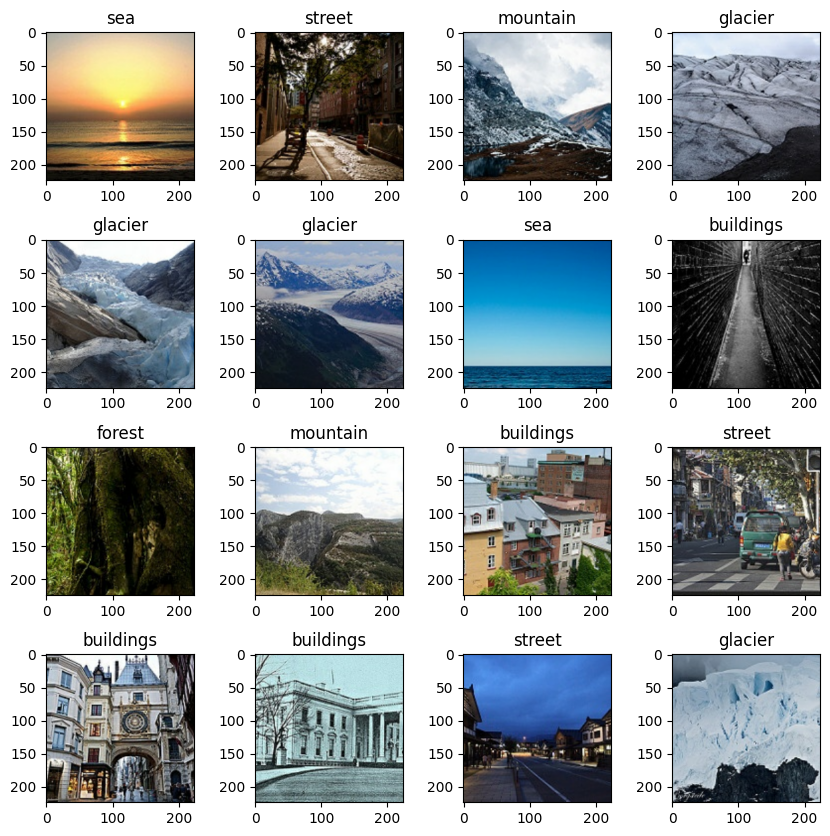

In [62]:
#showing image of training data
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  

In [65]:
#Size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 6)


# Building Model

# VGG Model

In [66]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=6,
                   weights='imagenet')
VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))
VGG_model.add(Dense(6, activation='softmax'))
pretrained_model.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [68]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [69]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [66]:
VGG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

In [21]:
epochs=4
history2 = VGG_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
callbacks=[callback]
)

Epoch 1/4

439/439 [==============================] - 1995s 5s/step - loss: 0.4069 - accuracy: 0.8538 - val_loss: 0.3872 - val_accuracy: 0.8557

Epoch 2/4

439/439 [==============================] - 1996s 5s/step - loss: 0.3858 - accuracy: 0.8566 - val_loss: 0.4303 - val_accuracy: 0.8357

Epoch 3/4

439/439 [==============================] - 1989s 5s/step - loss: 0.3829 - accuracy: 0.8583 - val_loss: 0.4046 - val_accuracy: 0.8480

Epoch 4/4

439/439 [==============================] - 1991s 5s/step - loss: 0.3727 - accuracy: 0.8624 - val_loss: 0.3924 - val_accuracy: 0.8580


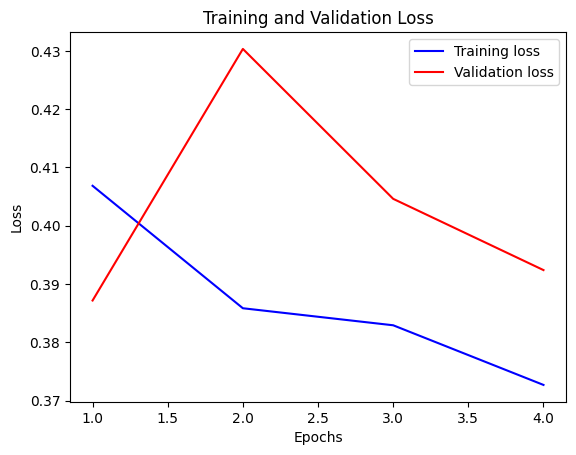

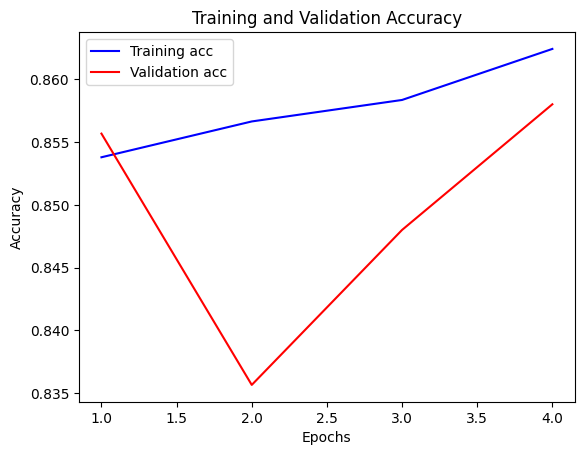

In [23]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Alexnet

In [75]:
train_ds = train_datagen.flow_from_directory(
  train_folder,   # Path to the training data
  seed=123,
  target_size=(227, 227), # Resize images to this size
  batch_size=32  , # Number of images in each batch
  class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)
val_ds = test_datagen.flow_from_directory(
  valid_folder,
  seed=123,
  target_size=(227, 227),
  batch_size=32)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [75]:
#Size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


In [76]:
#normalizing image
train_ds=train_ds.map(lambda x,y:(x/255,y))
val_ds=val_ds.map(lambda x,y:(x/255,y))

In [79]:
model = Sequential()
# Convolution Step 1
model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(227, 227, 3), activation = 'relu'))
# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Convolution Step 2
model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
model.add(BatchNormalization())
# Convolution Step 3
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 4
model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
model.add(BatchNormalization())
# Convolution Step 5
model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
model.add(BatchNormalization())
# Flattening Step
model.add(Flatten())
# Full Connection Step
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Adjusted output layer for 6 classes
model.add(Dense(units = 6, activation = 'softmax'))

In [80]:
# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [81]:
# Checking Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 27, 27, 96)        384       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                      

In [83]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

439/439 [==============================] - 1121s 3s/step - loss: 1.6775 - accuracy: 0.4716 - val_loss: 1.9040 - val_accuracy: 0.3663 - lr: 0.0010


In [84]:
history = model.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/7
439/439 [==============================] - 1092s 2s/step - loss: 1.2318 - accuracy: 0.5794 - val_loss: 2.2909 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 2/7
439/439 [==============================] - 1094s 2s/step - loss: 1.1257 - accuracy: 0.6180 - val_loss: 1.2839 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 3/7
439/439 [==============================] - 1095s 2s/step - loss: 1.0264 - accuracy: 0.6490 - val_loss: 4.7248 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 4/7
439/439 [==============================] - 1074s 2s/step - loss: 0.9970 - accuracy: 0.6688 - val_loss: 2.4653 - val_accuracy: 0.5403 - lr: 0.0010
Epoch 5/7
439/439 [==============================] - 1088s 2s/step - loss: 0.9652 - accuracy: 0.6720 - val_loss: 0.9641 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 6/7
439/439 [==============================] - 1098s 3s/step - loss: 0.9427 - accuracy: 0.6860 - val_loss: 1.1608 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 7/7
439/439 [==============================] - 1083s 2s/st

# GoogleNet

In [76]:
train_ds = train_datagen.flow_from_directory(
    train_folder,
    seed=123,
    target_size=(224, 224),  # Specify the target size of the images
    batch_size=32
)

val_ds = test_datagen.flow_from_directory(
    valid_folder,
    seed=123,
    target_size=(224, 224),  # Specify the target size of the images
    batch_size=32
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [44]:
from keras.layers import Input,MaxPool2D,Concatenate,AvgPool2D

In [ ]:
def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = AvgPool2D(7, strides=1)(x)
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [80]:
input_shape=(224,224,3)
n_classes=6
model=googlenet(input_shape,n_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_238 (Conv2D)         (None, 112, 112, 64)         9472      ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_55 (MaxPooli  (None, 56, 56, 64)           0         ['conv2d_238[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_239 (Conv2D)         (None, 56, 56, 64)           4160      ['max_pooling2d_55[0][0]

In [83]:
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [84]:
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)

Epoch 1/20
439/439 [==============================] - 2007s 5s/step - loss: 1.7872 - accuracy: 0.2026 - val_loss: 1.7761 - val_accuracy: 0.1867 - lr: 0.0010
Epoch 2/20
439/439 [==============================] - 1950s 4s/step - loss: 1.7112 - accuracy: 0.2403 - val_loss: 1.5663 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 3/20
439/439 [==============================] - 1974s 4s/step - loss: 1.0902 - accuracy: 0.5579 - val_loss: 1.0047 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 4/20
439/439 [==============================] - 1990s 5s/step - loss: 0.8767 - accuracy: 0.6575 - val_loss: 0.7780 - val_accuracy: 0.7087 - lr: 0.0010
Epoch 5/20
439/439 [==============================] - 1979s 5s/step - loss: 0.7944 - accuracy: 0.6967 - val_loss: 0.7364 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 6/20
439/439 [==============================] - 1929s 4s/step - loss: 0.7378 - accuracy: 0.7193 - val_loss: 0.6815 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 7/20
439/439 [==============================] - 1912

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()